In [60]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

In [61]:
df = pd.read_csv('model_data.csv')

#limit to second 100,000
#df = df.iloc[:350000].reset_index(drop=True)

In [62]:
# Drop unneeded columns
columns_to_drop = ['Unnamed: 0', 'exchange', 'bid', 'ask', 'trades', 'best_bid', 'best_ask', 'trade_id', 'product_id']
df_trades = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Map side to binary
df_trades['side'] = df_trades['side'].map({'SELL': 0, 'BUY': 1})

# Sort and scale
df_trades = df_trades.sort_values('time')
scaler = MinMaxScaler(feature_range=(0, 1))
df_trades['price_scaled'] = scaler.fit_transform(df_trades[['price']])


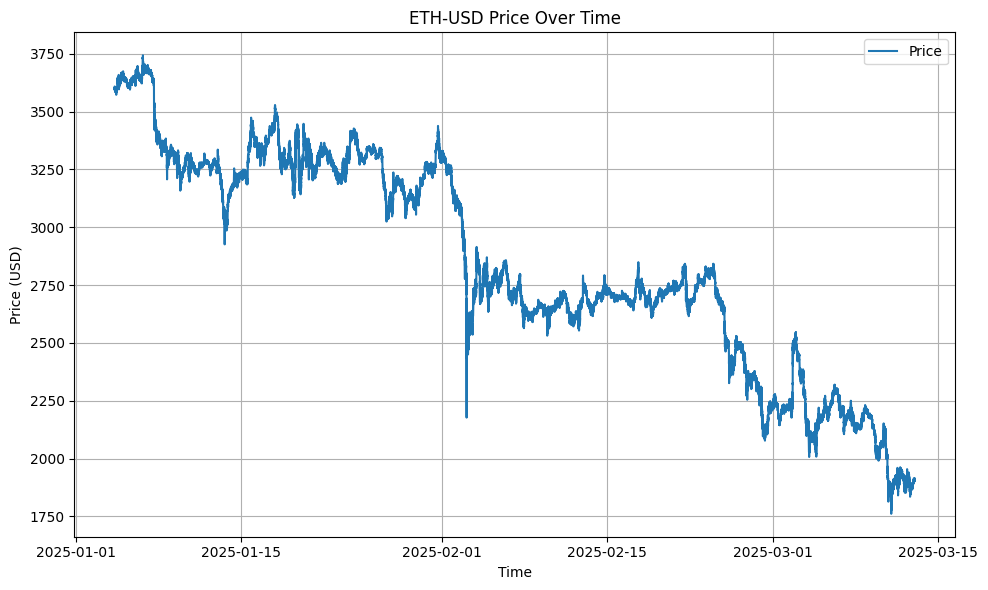

In [63]:
# Convert 'time' to datetime, coercing errors
df_trades['time'] = pd.to_datetime(df_trades['time'], errors='coerce')

# Drop rows where 'time' is NaT (invalid date)
df_trades = df_trades.dropna(subset=['time'])

# Convert 'price' column to numeric
df_trades['price'] = pd.to_numeric(df_trades['price'])

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df_trades['time'], df_trades['price'], linestyle='-', label='Price')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.title('ETH-USD Price Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [64]:
# Compute percent difference
df_trades['pct_change'] = df_trades['price'].pct_change() * 100  # Convert to percentage
df_trades['rolling_std_5'] = df_trades['price'].rolling(window=5).std().fillna(0)
df_trades['rolling_std_10'] = df_trades['price'].rolling(window=10).std().fillna(0)
df_trades['abs_pct_change'] = df_trades['pct_change'].abs()
df_trades['is_spike'] = (df_trades['abs_pct_change'] > 2).astype(int)
 
# Drop the first row since pct_change for first row is NaN
df_trades = df_trades.dropna(subset=['pct_change']).reset_index(drop=True)

df_trades = df_trades.drop(columns=[col for col in df_trades.columns if col.startswith("Unnamed")])

In [65]:
df_trades['sma_5'] = df_trades['price_scaled'].rolling(window=5).mean()
df_trades['momentum'] = df_trades['price_scaled'] - df_trades['price_scaled'].shift(5)
df_trades.dropna(subset=['sma_5', 'momentum'], inplace=True)
df_trades.head()

,price,size,time,side,price_scaled,pct_change,rolling_std_5,rolling_std_10,abs_pct_change,is_spike,sma_5,momentum
5,3597.69,0.003707,2025-01-04 06:40:00.442719+00:00,1.0,0.926538,-0.000556,0.198192,0.000000,0.000556,0,0.926592,-0.000636
6,3597.70,0.006879,2025-01-04 06:40:17.994423+00:00,0.0,0.926544,0.000278,0.011402,0.000000,0.000278,0,0.926547,-0.000227
7,3597.70,0.015755,2025-01-04 06:40:32.624359+00:00,0.0,0.926544,0.000000,0.011402,0.000000,0.000000,0,0.926546,-0.000005
8,3597.70,0.000804,2025-01-04 06:40:48.741554+00:00,0.0,0.926544,0.000000,0.007071,0.407934,0.000000,0,0.926544,-0.000010
9,3597.70,0.119900,2025-01-04 06:41:04.481562+00:00,0.0,0.926544,0.000000,0.004472,0.403651,0.000000,0,0.926543,-0.000005


In [66]:
# Create sequences
sequence_length = 10
forecast_steps = 5

X = []
y = []

prices = df_trades['price_scaled'].values
sma_5 = df_trades['sma_5'].values
momentum = df_trades['momentum'].values
pct_change = df_trades['pct_change'].values
rolling_std_5 = df_trades['rolling_std_5'].values
rolling_std_10 = df_trades['rolling_std_10'].values
is_spike = df_trades['is_spike'].values

for i in range(len(prices) - sequence_length - forecast_steps):
    row = []
    row.append(prices[i:i + sequence_length])
    row.append(sma_5[i:i + sequence_length])
    row.append(momentum[i:i + sequence_length])
    row.append(rolling_std_5[i:i + sequence_length])
    row.append(rolling_std_10[i:i + sequence_length])
    row.append(is_spike[i:i + sequence_length])
    X.append(row)
    y.append(prices[i + sequence_length + forecast_steps - 1])

X = np.array(X)
y = np.array(y)

# Flatten sequences
X = X.reshape(X.shape[0], -1)


In [67]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train LightGBM
model = LGBMRegressor(
    max_depth=12,
    num_leaves=128,
    min_child_samples=10,
    learning_rate=0.03,
    n_estimators=300,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
)

model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12766
[LightGBM] [Info] Number of data points in the train set: 1055076, number of used features: 58
[LightGBM] [Info] Start training from score 0.606857
Test MSE: 0.013456650357655775


In [68]:
# Inverse transform the predictions and test labels to get original prices
predictions = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

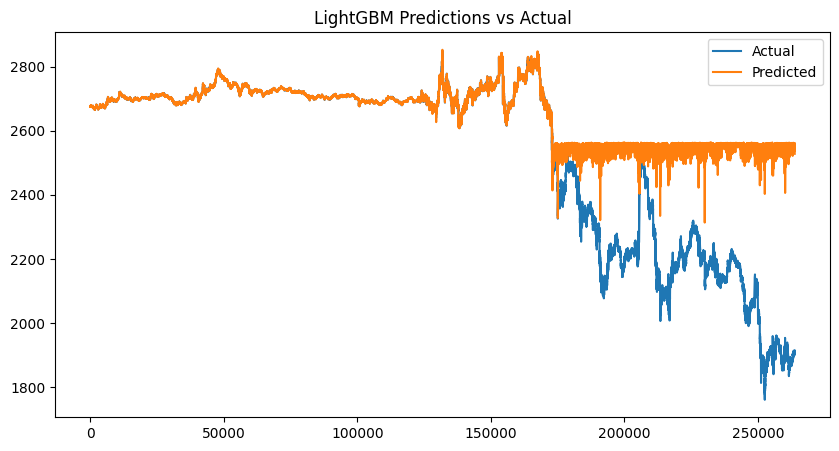

In [69]:
# Optional: plot predictions
plt.figure(figsize=(10,5))
plt.plot(y_test_original, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title("LightGBM Predictions vs Actual")
plt.show()
